In [1]:
%pylab inline
import os
import pandas as pd
import numpy as np
import sys



from sklearn.preprocessing import LabelBinarizer
import imgaug as ia
import imgaug.augmenters as iaa
import random
import cv2
from matplotlib import pyplot as plt
import glob
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras import optimizers

PARENT_DIR = os.path.dirname(os.getcwd())
sys.path.insert(1, PARENT_DIR+"\\scripts")
import utilities

PARENT_DIR

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


'D:\\DS_projects\\yapikredi_cv'

In [2]:
DATA_DIR = PARENT_DIR + "\\data\\"
OUT_DIR = PARENT_DIR + "\\output\\"
DEBUG_MOD = True # False #
MODEL_NAME = OUT_DIR + "model_part1.h5"

In [3]:
images_file_name = OUT_DIR + "images.pkl"
labels_file_name = OUT_DIR + "labels.pkl"

test_img_file_name = OUT_DIR + "test_img.pkl"
test_lbl_file_name = OUT_DIR + "test_lbl.pkl"

# parsing image

In [4]:
if not os.path.isfile(images_file_name):
    print("parsing images")
    # train data
    folder_path = DATA_DIR+"train"
    x_data, y_data = utilities.parse_files(folder_path, images_file_name, labels_file_name)
     # testing and error analysis
    folder_path = DATA_DIR+"test"
    x_test, y_test = utilities.parse_files(folder_path, test_img_file_name, test_lbl_file_name)
else:
    print("loading images")
    x_data, y_data = utilities.read_data(images_file_name, labels_file_name)
    x_test, y_test = utilities.read_data(test_img_file_name, test_lbl_file_name)

loading images


In [5]:
df_sim_tab, n_sample = utilities.create_similarity_table(y_data)
df_sim_tab_test, n_sample_test = utilities.create_similarity_table(y_test)
n_class = np.max(y_data)
df_sim_tab["gr_truth"] = (df_sim_tab["person1"]==df_sim_tab["person2"]).astype(int)
df_sim_tab_test["gr_truth"] = (df_sim_tab_test["person1"]==df_sim_tab_test["person2"]).astype(int)
df_sim_tab.tail(24)

person1  img1no  person2  img2no  score  gr_truth
270456       79     728       79     733     -1         1
270457       79     728       79     734     -1         1
270458       79     728       79     735     -1         1
270459       79     729       79     730     -1         1
270460       79     729       79     731     -1         1
270461       79     729       79     732     -1         1
270462       79     729       79     733     -1         1
270463       79     729       79     734     -1         1
270464       79     729       79     735     -1         1
270465       79     730       79     731     -1         1
270466       79     730       79     732     -1         1
270467       79     730       79     733     -1         1
270468       79     730       79     734     -1         1
270469       79     730       79     735     -1         1
270470       79     731       79     732     -1         1
270471       79     731       79     733     -1         1
270472       79     731       79     734     -1         1
270473       79     731       79     735     -1         1
270474       79     732       79     733     -1         1
270475       79     732       79     734     -1         1
270476       79     732       79     735     -1         1
270477       79     733       79     734     -1         1
270478       79     733       79     735     -1         1
270479       79     734       79     735     -1         1

##  balance similarity table using random sampling
Imbalance in similar and non-similar data



In [6]:
sampled_df = utilities.balance_data(df_sim_tab, y_data)
#sampled_df_test = utilities.balance_data(df_sim_tab_test, y_test)

0    266461
1      4019
Name: gr_truth, dtype: int64
i_person:  1  is processing

i_person:  2  is processing

i_person:  3  is processing

i_person:  4  is processing

i_person:  6  is processing

i_person:  7  is processing

i_person:  8  is processing

i_person:  9  is processing

i_person:  10  is processing

i_person:  11  is processing

i_person:  12  is processing

i_person:  14  is processing

i_person:  15  is processing

i_person:  16  is processing

i_person:  17  is processing

i_person:  18  is processing

i_person:  19  is processing

i_person:  20  is processing

i_person:  21  is processing

i_person:  22  is processing

i_person:  23  is processing

i_person:  24  is processing

i_person:  26  is processing

i_person:  27  is processing

i_person:  28  is processing

i_person:  29  is processing

i_person:  30  is processing

i_person:  31  is processing

i_person:  33  is processing

i_person:  35  is processing

i_person:  37  is processing

i_person:  39  is process

### checking sampling done correctly and index is reset

In [7]:
sampled_df[sampled_df["gr_truth"]==1] , print("\n"), sampled_df.loc[sampled_df["person1"]==8,"gr_truth"].value_counts()

(     person1 img1no person2 img2no score gr_truth
 0          1      0       1      1    -1        1
 1          1      0       1      2    -1        1
 2          1      0       1      3    -1        1
 3          1      0       1      4    -1        1
 4          1      0       1      5    -1        1
 ...      ...    ...     ...    ...   ...      ...
 9187      79    732      79    734    -1        1
 9188      79    732      79    735    -1        1
 9189      79    733      79    734    -1        1
 9190      79    733      79    735    -1        1
 9191      79    734      79    735    -1        1
 
 [4019 rows x 6 columns], None, 0    86
 1    66
 Name: gr_truth, dtype: int64)

n_sample_data = len(sampled_df)
concat_img = np.zeros((n_sample_data, x_data.shape[1], x_data.shape[2]*2, x_data.shape[3]))
y_label = np.zeros(n_sample_data, dtype=int0)
for i in range(n_sample_data):
    row = sampled_df.iloc[i]
    img1no, img2no = row["img1no"], row["img2no"]
    concat_img[i] = np.concatenate((x_data[img1no], x_data[img2no]), axis=1)
    y_label[i] = row["gr_truth"]
x_data = concat_img.copy();
y_data = y_label.copy()

In [8]:
x_data, y_data = utilities.differ_images(sampled_df, x_data)
x_test, y_test = utilities.differ_images(df_sim_tab_test, x_test)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
n_data = x_data.shape; n_test = x_test.shape 
x_data = scaler.fit_transform(x_data.reshape((n_data[0],-1))).reshape((n_data[0],n_data[1],n_data[2],n_data[3]))
x_test = scaler.transform(x_test.reshape((n_test[0],-1))).reshape((n_test[0],n_test[1],n_test[2],n_test[3]))

## checking data parsing done well

0


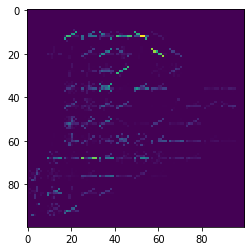

1


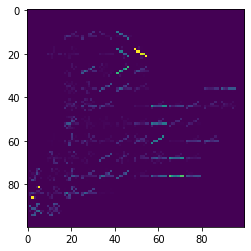

2


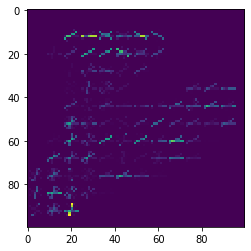

3


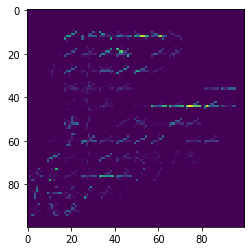

4


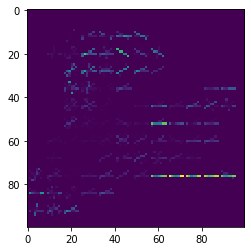

5


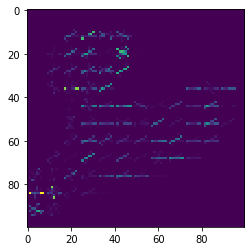

6


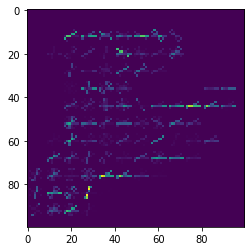

7


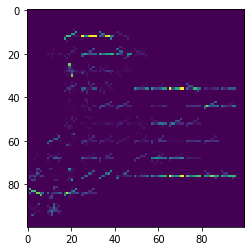

8


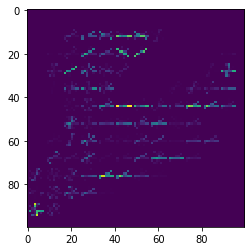

9


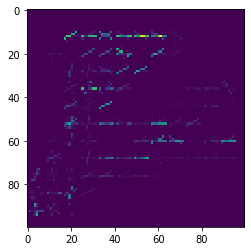

10


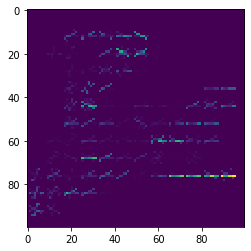

11


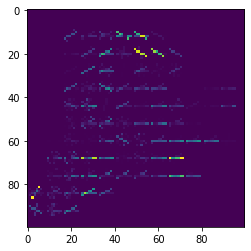

12


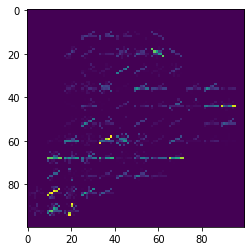

13


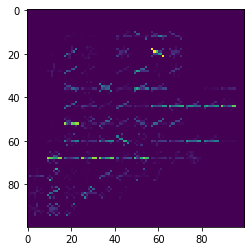

14


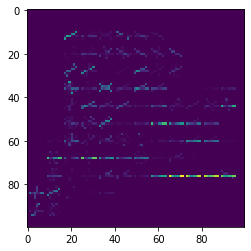

15


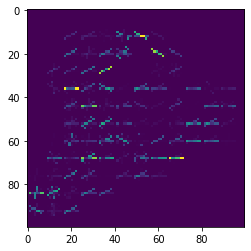

16


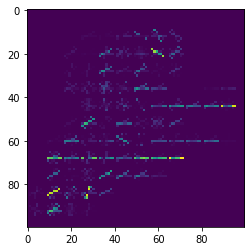

17


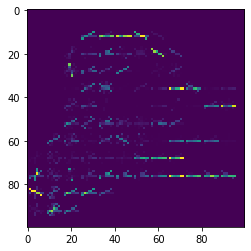

18


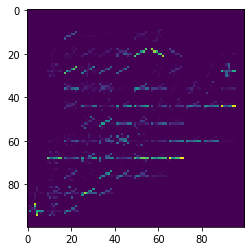

19


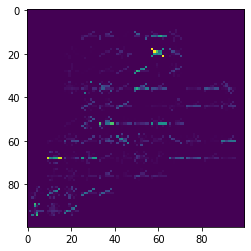

20


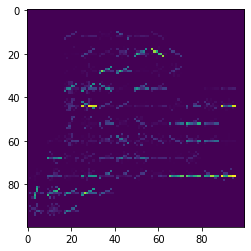

21


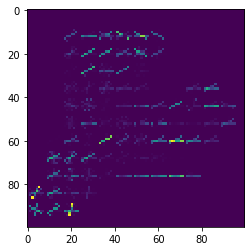

22


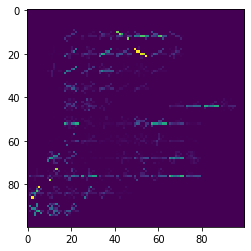

23


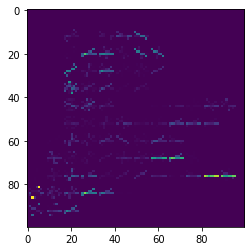

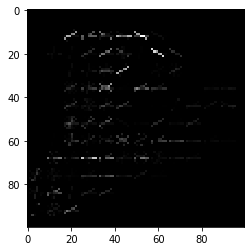

In [10]:
for i in range(24):
    print(i)
    plt.imshow(x_data[i][:,:,0])
    plt.show()

plt.imshow(x_test[0][:,:,0], cmap='gray',clim=(0,1))
plt.show()



## train validation seperation

In [12]:
# train validation seperation
x_train, x_val, y_train, y_val, n_class = utilities.seperate_train_validation_data(x_data, y_data)
#y_train, y_val = np.squeeze(y_train), np.squeeze(y_val)

number of data for each class: [[   0 5173]
 [   1 4019]]
unique labels [0 1]
n_class: 1


# Build model
## Design of model
Our Architecture is as follows:

conv => max pool => dropout => conv => max pool => dropout => fully connected => fully connected

But depending on the performance, this architecture was changed and hyperparameter tuning was also done.


since there are more than 2 classes to detect, categorical cross_entropy is used as loss function whose equation is below:
![cce](cce.png)

**Activation functions:** are selected as ReLU in order to cancel out vanishing gradient and provide non linearity to model. But the last Dense layer activation must be chosen as softmax because its normalized form of values so, it can be said that it also shows the probability of each class to be.  

there are also other criterias for multi class classification


* optimizer : adam, RMSprop and SGD after all trials 
    * SGD: best val_accuracy =  0.67656
    * adam: best val_accuracy =  0.8649
    * RMSprop: best val_accuracy =  0.93541
    
## Fine tuning
there are two options for hyper tuning
* reduce fixed image size
* reduce filter number

initially fixed_img_size = (200,200)
filter number first conv =  64
filter number first conv =  128

after many trials best conf
initially fixed_img_size = (100,100)
filter number first conv =  4
filter number first conv =  8

In [13]:
np.histogram(y_train), print("\n"), np.histogram(y_val)

((array([4655,    0,    0,    0,    0,    0,    0,    0,    0, 3617],
        dtype=int64),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])),
 None,
 (array([518,   0,   0,   0,   0,   0,   0,   0,   0, 402], dtype=int64),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])))

n_class:  1 	loss:  binary_crossentropy
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 4)       104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 4)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 25, 8)         0         
_________________________________________________________________
flatten_1 (Fla

 - 24s - loss: 0.2310 - accuracy: 0.9030 - val_loss: 0.2665 - val_accuracy: 0.8891

Epoch 00038: val_accuracy did not improve from 0.90435
Epoch 39/100
 - 24s - loss: 0.2355 - accuracy: 0.8971 - val_loss: 0.2337 - val_accuracy: 0.8989

Epoch 00039: val_accuracy did not improve from 0.90435
Epoch 40/100
 - 24s - loss: 0.2319 - accuracy: 0.9011 - val_loss: 0.2371 - val_accuracy: 0.8946

Epoch 00040: val_accuracy did not improve from 0.90435
Epoch 41/100
 - 24s - loss: 0.2267 - accuracy: 0.9043 - val_loss: 0.2288 - val_accuracy: 0.9000

Epoch 00041: val_accuracy did not improve from 0.90435
Epoch 42/100
 - 24s - loss: 0.2319 - accuracy: 0.9035 - val_loss: 0.2359 - val_accuracy: 0.8967

Epoch 00042: val_accuracy did not improve from 0.90435
Epoch 43/100
 - 24s - loss: 0.2259 - accuracy: 0.9061 - val_loss: 0.2325 - val_accuracy: 0.9000

Epoch 00043: val_accuracy did not improve from 0.90435
Epoch 44/100
 - 23s - loss: 0.2309 - accuracy: 0.9045 - val_loss: 0.2385 - val_accuracy: 0.8946

Epoc

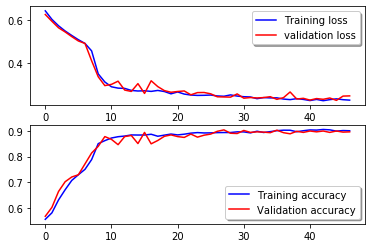

In [14]:
MODEL_NAME = OUT_DIR + "cnn_model.h5"
b_build_model =          True # False #
if b_build_model:
    model = utilities.build_and_fit_cnn_model(x_train, y_train, x_val,y_val, n_class, MODEL_NAME)
else:
    img_shape = x_train[0].shape
    model, call_backs = utilities.initialize_cnn_model(img_shape, n_class, MODEL_NAME)

from keras.models import Model
layer_name = 'flatten_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
#intermediate_output = intermediate_layer_model.predict(data)

## feature generation from this probabilities
* best component is chosen after many trials to get the highest auc value 

In [15]:
cum_result_df = utilities.calculate_similarity_table(x_test, y_test, df_sim_tab_test, model)
cum_result_df.to_csv("similarity_table.csv")
cum_result_df.head(24)

(20706, 6) (20706, 1)


person1  img1no  person2  img2no     score  gr_truth
0        80       0       80       1  0.918572         1
1        80       0       80       2  0.989612         1
2        80       0       80       3  0.352000         1
3        80       0       80       4  0.899075         1
4        80       0       80       5  0.991864         1
5        80       0       80       6  0.740994         1
6        80       0       80       7  0.214858         1
7        80       0       80       8  0.996166         1
8        80       0       80       9  0.663886         1
9        80       0       80      10  0.951930         1
10       80       0       80      11  0.993927         1
11       80       0       83      12  0.098898         0
12       80       0       83      13  0.002968         0
13       80       0       83      14  0.028232         0
14       80       0       83      15  0.075567         0
15       80       0       83      16  0.013083         0
16       80       0       83      17  0.011066         0
17       80       0       83      18  0.020526         0
18       80       0       83      19  0.005473         0
19       80       0       83      20  0.010563         0
20       80       0       83      21  0.013465         0
21       80       0       83      22  0.022347         0
22       80       0       83      23  0.001535         0
23       80       0       84      24  0.573239         0

## roc and auc analysis

roc_auc:  0.9137423379556814 best_thresh 0.5322292


(          fpr      tpr     1-fpr        tf  thresholds
 928  0.145884  0.85205  0.854116 -0.002066    0.532229, 0.9137423379556814)

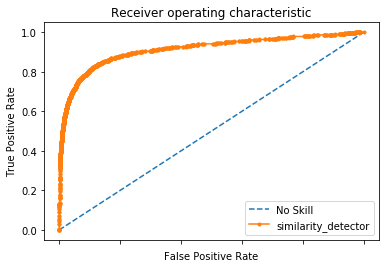

In [16]:
cum_result_df["gr_truth"] = cum_result_df["person1"] == cum_result_df["person2"]
cum_result_df["gr_truth"] = cum_result_df["gr_truth"].astype(int)
roc_auc, best_thresh, roc = utilities.plot_roc_curve(cum_result_df)
best_thresh, roc_auc

In [17]:
threshold = best_thresh["thresholds"].values[0]

result = utilities.similarity_prediction(cum_result_df, threshold)
result["pred"] = result["pred"].astype(int)
result["gr_truth"] = result["gr_truth"].astype(int)

result.head(24)

person1  img1no  person2  img2no     score  gr_truth  pred
0        80       0       80       1  0.918572         1     1
1        80       0       80       2  0.989612         1     1
2        80       0       80       3  0.352000         1     0
3        80       0       80       4  0.899075         1     1
4        80       0       80       5  0.991864         1     1
5        80       0       80       6  0.740994         1     1
6        80       0       80       7  0.214858         1     0
7        80       0       80       8  0.996166         1     1
8        80       0       80       9  0.663886         1     1
9        80       0       80      10  0.951930         1     1
10       80       0       80      11  0.993927         1     1
11       80       0       83      12  0.098898         0     0
12       80       0       83      13  0.002968         0     0
13       80       0       83      14  0.028232         0     0
14       80       0       83      15  0.075567         0     0
15       80       0       83      16  0.013083         0     0
16       80       0       83      17  0.011066         0     0
17       80       0       83      18  0.020526         0     0
18       80       0       83      19  0.005473         0     0
19       80       0       83      20  0.010563         0     0
20       80       0       83      21  0.013465         0     0
21       80       0       83      22  0.022347         0     0
22       80       0       83      23  0.001535         0     0
23       80       0       84      24  0.573239         0     1

best_thresh to optimize auc is 0.7039580643177032

## precision recall plot analysis

Logistic: f1=0.387 auc=0.639
Best Threshold=0.914674, F-Score=0.611


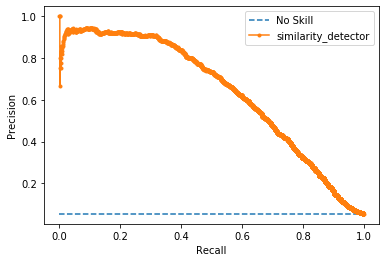

In [18]:
precision, recall, thresholds = utilities.plot_precision_recall_curve(result)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

* as seen in precision-recal, best threshold is 0.97. furthermore, it is also suitable for fraud case since the system precision is quite high and secure to run on real operations

### Confusion Matrix wrt best threshold of ROC analysis

In [19]:
from sklearn.metrics import classification_report
print(classification_report(result["gr_truth"], result["pred"]))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     19584
           1       0.25      0.85      0.39      1122

    accuracy                           0.85     20706
   macro avg       0.62      0.85      0.65     20706
weighted avg       0.95      0.85      0.89     20706



### Confusion Matrix wrt best threshold of precision recall curve analysis

In [22]:
threshold = thresholds[ix]

result = utilities.similarity_prediction(cum_result_df, threshold)
result["pred"] = result["pred"].astype(int)

print(classification_report(result["gr_truth"], result["pred"]))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19584
           1       0.66      0.57      0.61      1122

    accuracy                           0.96     20706
   macro avg       0.82      0.78      0.80     20706
weighted avg       0.96      0.96      0.96     20706



### compare the model with 0.5 threshold

In [21]:
threshold = 0.5

result = utilities.similarity_prediction(cum_result_df, threshold)
result["pred"] = result["pred"].astype(int)

print(classification_report(result["gr_truth"], result["pred"]))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     19584
           1       0.24      0.86      0.37      1122

    accuracy                           0.84     20706
   macro avg       0.61      0.85      0.64     20706
weighted avg       0.95      0.84      0.88     20706



# Conclusion

* first of all, probability features are not **informative enough to seperate the new people** well as seen in roc curve and precision recall curve. Therefore, other feature generation approauch using the cnn_model with train data can be investigated. due to the lack of time , i could not optimize yet


* **in order to reduce fraud events**, you must get **the highest precision value of 1s**. in this case, thresh=0.5 results in the best precision value for 1s. Furthermore, **roc curve analysis threshold** is better than precision-recal curve's in 1's precision value.  